In [1]:
import os
import math
from math import *
import statistics
from statistics import *
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
plt.rcParams["svg.fonttype"]="none"

## 1 Lecture de fichiers

In [2]:
#folder_path="/Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/GIT_DEV/2_descripteurs/KAWA_Analyses-1s"
folder_path="/Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/GIT_DEV2/2_descripteurs/KAWA_Analyses-2.5s"

filelist = []
for path, dirs, files in os.walk(folder_path):
    for filename in files:
        if 'txt' in filename :
                filelist.append(filename)
filelist.sort()
print("nombre de fichiers lus : " , len(filelist))
#print(filelist)

#get classes in string
class_path=os.chdir("/Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/GIT_DEV2/2_descripteurs/KAWA_Analyses-2.5s/")


nombre de fichiers lus :  36


In [53]:
# read filetxt and generate array S
def read(filetext):
    with open(filetext) as f:
        mylist = f.read().splitlines()
        for x in range(8):
            mylist.pop(0)
        S=[]
        for element in reversed(mylist):
            element2=[float(i) for i in element.split()]
            S.append(element2)
        return S

file0 = filelist[1]
S0 = read(file0)
file1 = filelist[2]
S1 = read(file1)
#print ("S1 est : " , S1)
file2 = filelist[3]
S2 = read(file2)
file3 = filelist[5]
S3 = read(file3)
file4 = filelist[13]
S4 = read(file4)
file5 = filelist[18]
S5 = read(file5)

print ("S0 est : " , file0)
print ("S1 est : " , file1)
print ("S2 est : " , file2)
print ("S3 est : " , file3)
print ("S4 est : " , file4)

S0 est :  (0_noise_sr44100_deb00_00_00_t02_00.txt
S1 est :  (0_pink_sr44100_deb00_00_00_t02_00.txt
S2 est :  (0_sinus500_sr44100_deb00_00_00_t02_00.txt
S3 est :  (la)[PinkNoise]Pk_05Hz_reg.wav_sr44100_deb00_01_00_t02_50_pas10_00.txt
S4 est :  (trim-L-la)[clock_alarm]bbc_ Portable electric alarm clock_07070161.wav_sr44100_deb00_01_00_t02_50_pas10_00.txt


In [4]:
# plus file name unite comme secondes 
def timetxt (filetext):
    str_L = filetext.rsplit(sep='_')
    test = 0
    result = 0
    for str in str_L:
        if test == 3:
            cent = int(str)
            result+=(cent/100)
            test = 0
        if test == 2:
            sec = int(str)
            test = 3
            result+=sec
        if re.search('deb', str):
            test = 1
            min = int(str[4-5])
            result+=(min*60)
            test = 2
    return result

#print(timetxt("EntranceEICcreation_m.wav_sr44100_deb00_00_00_t02_50_pas10_00.txt"))
#timetxt("AlanStivell_PopPlinn_1971m.wav_sr44100_deb00_45_00_t02_50_pas02_50.txt")


## 2 Utilitaires

In [5]:
def f_to_midi (f) :
    return 69+12*log(f/440,2)

#print ("note de freq 261Hz :" , f_to_midi (261))

def midi_to_f (n) :
    return 440*2**((n-69)/12)

#print ("frequence de note 60 :" , midi_to_f (60), "Hz")

def dx2x(intervalles):
    res=[0]
    for i in range (len (intervalles)):
        res.append(res[i]+intervalles[i-1])
    return res
               
def a2db (a):
    if(a<=0.000001):res = -120
    else:
        res = 20*log(a,10)
    return res

# version limitée à un ambitus 0 (0.001) - 60dB (1)               
def a2db60 (a):
    if(a<=0.001):res = 0
    else:res = 60+20*log(a,10)
    return res

#print ("amp = 0.0 => amplitude en dB :" , round(a2db(0.000001), 3), "dB")
#print ("amp = 0.0001 => amplitude en dB :" , round(a2db(0.0001), 3), "dB")
#print ("amp = 0.5 => amplitude en dB :" , round(a2db(0.5), 3), "dB")
#print ("amp = 1 => amplitude en dB :" , a2db(1), "dB")
#print ("amp60 = 0 => amplitude60 en dB :" , a2db60(0), "dB")
#print ("amp60 = 1 => amplitude60 en dB :" , a2db60(1), "dB")


In [31]:
# les intervalles des 27 bandes
f_ls = [21.5,32.3,43.1,53.8,64.6,86.1,107.7,140.0,172.3,215.3,269.2,344.5,441.4,549.1,699.8,872.1,1109.0,1388.9,1755.0,2217.9,2788.5,3520.7,4435.8,5587.9,7041.4,8871.7,11175.7,14071.9]

LtailleLigne = [] # liste des tailles des lignes
for k in range(27):
    LtailleLigne.append(4+2*k)

f_c = [] # frequences centrales des bandes
for i in range(len(f_ls)-1):
    f_c.append(sqrt(f_ls[i+1]*f_ls[i]))
    
f_c_midi = []
for i in range(len(f_c)):
    f_c_midi.append(f_to_midi(f_c[i]))

f_c_moy = 0 
for i in range(len(f_c)):
    f_c_moy += f_c[i]
    f_c_moy /= 27
    
f_c_gmoy = 0
for i in range(len(f_c)):
    f_c_gmoy += log(f_c[i], 2)
    f_c_gmoyR =  2**(f_c_gmoy/27)

#print("len(f_ls) :", len(f_ls), "bornes")

W=[]

for i in range(len(f_ls)-1):
    W.append(round(f_ls[i+1]-f_ls[i], 2))
    
#print("w :" , W)       
#print ("f_c :", f_c)
#print ("f_c_moy :", round(f_c_moy,1), "Hz") # (en Hz) moyenne des frequences des centres des bandes 
#print ("f_c_gmoyR :", round(f_c_gmoyR,1), "Hz") # (en Hz) moyenne des centres calculée par les notes MIDI
#print ("f_c_gmoyR :", f_c_gmoyR2) # (en Hz) moyenne des centres calculée par les notes MIDI

f_cA = np.asarray(f_c)
f_cA = f_cA[:, np.newaxis]
#print (round(3.149 , 2))

## 3 Descripteurs spectraux

In [32]:
# moyennes des amplitudes par ligne (des fréquences basses vers hautes)
def moy_des_amps (S):
    Sk_mean=[]
    for k in range(27):
        sum_s=0
        for j in range(4+2*k):
            sum_s+=S[k][j]
        Sk_mean.append(sum_s/(4+2*k))
    return Sk_mean

#print("amps:",moy_des_amps(S1))

# moyennes geometriques des amplitudes par ligne (des fréquences basses vers hautes)
def gmoy_des_amps (S):
    Sk_gmean=[]
    for k in range(27):
        prod_s=1
        for j in range(4+2*k):
            prod_s*=S[k][j]
        Sk_gmean.append(prod_s**(1/(4+2*k)))
    return Sk_gmean

#print("gamps:",gmoy_des_amps(S1))

def produit_des_amps (S):
    Sk_prod=[]
    K = 27
    for k in range(27):
        prod_s=1
        for j in range(4+2*k):
            prod_s*=S[k][j]
        Sk_prod.append(prod_s**(1/(K*(K+3))))
    return Sk_prod

#print("produit amps S2:",produit_des_amps(S2))

In [33]:
#centroid
def centroid(S):
    Sk_mean = moy_des_amps(S)
    sum_sc=0
    sum_sfk=0
    for k in range(27):
        sum_sfk += Sk_mean[k]*f_c[k]
        sum_sc += Sk_mean[k]            
    if sum_sc == 0 :
        centroid=0
    else:
        centroid=sum_sfk/sum_sc
    #print('centroid' , centroid)
    return centroid

#print("centroid S1 :",round(centroid(S1)),"Hz")

#variance et sd
def variance(S):
    Sk_mean=[]
    variance = 0
    for k in range(27):
        sum_s=0
        for j in range(4+2*k):
            sum_s+=S[k][j]
        Sk_mean.append(sum_s/(4+2*k))
    sum_var=0
    sum_skm=0
    for k in range(27):
        sum_var+=Sk_mean[k]*((f_c[k]-centroid(S))**2)
        sum_skm+=Sk_mean[k]
    if sum_skm>0:
        variance=sum_var/sum_skm
    return variance

# sd: 
def sd(filetext):
    sd=sqrt(variance(filetext))
    return sd

sd(S1)

3327.650199495966

In [34]:
# sd: biased standard deviation (N)
def sdLow(S):
    Sk_mean = moy_des_amps(S)
    sdLow = 0
    sum_sd=0
    sum_skm=0
    for k in range(27):
        diff=f_c[k]-centroid(S)
        if diff <0:
            sum_sd+=Sk_mean[k]*(diff**2)
            sum_skm+=Sk_mean[k]
    if sum_skm > 0:
        sdLow=sqrt(sum_sd/sum_skm)
    return sdLow

# sd: biased standard deviation (N)
def sdHigh(S):
    Sk_mean = moy_des_amps(S)
    sdHigh = 0
    sum_sd=0
    sum_skm=0
    for k in range(27):
        diff=f_c[k]-centroid(S)
        if diff >0:
            sum_sd+=Sk_mean[k]*(diff**2)
            sum_skm+=Sk_mean[k]
    if sum_skm > 0:
        sdHigh=sqrt(sum_sd/sum_skm)
    return sdHigh

    
def c_min_sdlow(S): 
    return round(centroid(S) - sdLow(S),1)

def c_plus_sdHi(S): 
    return round(centroid(S) + sdHigh(S),1)

print("centre-ecartlow S1:", c_min_sdlow(S1),"Hz")
print("centroid S1:", round(centroid(S1),1),"Hz")
print("centre+ecartHigh S1:", c_plus_sdHi(S1),"Hz")


centre-ecartlow S1: 443.1 Hz
centroid S1: 2374.0 Hz
centre+ecartHigh S1: 7581.2 Hz


In [35]:
#MIDI centroid
def midi_centroid(S):
    Sk_mean = moy_des_amps(S)
    sum_sc=0
    midi_centroid=0
    sum_sfk=0
    for k in range(27):
        sum_sfk+=Sk_mean[k]*f_to_midi(f_c[k])
        sum_sc+=Sk_mean[k]            
    if sum_sc > 0 :
        midi_centroid=sum_sfk/sum_sc
    #print('centroid' , centroid)
    return midi_centroid


In [36]:
#ecartHigh
def midi_ecartHigh(S): 
    Sk_mean = moy_des_amps(S) 
    sum_var=0 
    sum_skm=0
    varianceHigh = 0
    for k in range(27): 
        df = f_to_midi(f_c[k])-midi_centroid(S) 
        if df>0:
            sum_var+=Sk_mean[k]*(df**2)
            sum_skm+=Sk_mean[k]
    if sum_skm>0:
        varianceHigh=sum_var/sum_skm
    #print(\"variance\", variance)
    return sqrt(varianceHigh)

#ecartLow 
def midi_ecartLow(S): 
    Sk_mean = moy_des_amps(S) 
    sum_var=0 
    sum_skm=0
    varianceLow = 0
    for k in range(27): 
        df = f_to_midi(f_c[k])-midi_centroid(S) 
        if df<0:
            sum_var+=Sk_mean[k]*(df**2)
            sum_skm+=Sk_mean[k]
    if sum_skm>0:
        varianceLow=sum_var/sum_skm
    #print(\"variance\", variance)
    return sqrt(varianceLow)

def mc_min_eclow(S): 
    return round(midi_centroid(S) - midi_ecartLow(S),1)

def mc_plus_ecHi(S): 
    return round(midi_centroid(S) + midi_ecartHigh(S),1)

mcd = round(midi_centroid(S1),1)
mcd_eL = round(mc_min_eclow(S1),1)
mcd_eH = round(mc_plus_ecHi(S1),1)
print("centr-ecartLow S1:", mcd_eL,"MIDI /", round(midi_to_f(mcd_eL),1),"Hz") 
print("midi_centroid S1:", mcd,"MIDI /", round(midi_to_f(mcd)),"Hz")
print("centr+ecartHigh S1:", mcd_eH,"MIDI /", round(midi_to_f(mcd_eH),1),"Hz")

centr-ecartLow S1: 44.8 MIDI / 108.7 Hz
midi_centroid S1: 76.8 MIDI / 690 Hz
centr+ecartHigh S1: 107.0 MIDI / 3951.1 Hz


In [37]:
#midi spectral slope
def midi_spectral_slope_reg(S):
    f_csA_midi = np.asarray(f_c_midi)
    f_csA_midi = f_csA_midi[:, np.newaxis]
    Sk_meanA = np.asarray(moy_des_amps(S))
    Sk_meanA = Sk_meanA[:, np.newaxis]
    modeleReg = LinearRegression()
    modeleReg.fit(f_csA_midi, Sk_meanA)
    #plt.scatter(f_csA, Sk_meanA)
    return modeleReg

def midi_sp_slope (S):
    return midi_spectral_slope_reg(S).coef_[0][0]

def plot_slope(S):
    modeleReg = midi_spectral_slope_reg(S)
    f_csA_midi = np.asarray(f_c_midi)
    f_csA_midi = f_csA_midi[:, np.newaxis]
    Sk_meanA = np.asarray(moy_des_amps(S))
    Sk_meanA = Sk_meanA[:, np.newaxis]
    plt.scatter(f_csA_midi, Sk_meanA)

    #print("Sk_meanA : " , Sk_meanA)
    
    x_min = 10
    x_max = 130

    X_NEW = np.linspace(x_min, x_max, 100)
    X_NEW = X_NEW[:,np.newaxis]

    Y_NEW = modeleReg.predict(X_NEW)

    plt.plot(X_NEW, Y_NEW, color='coral', linewidth=3)
    plt.grid()
    plt.xlim(x_min, x_max)
    plt.ylim(0, 0.05)

    plt.title("regression linéaire > midislope", fontsize=10)
    plt.xlabel('f_cs_midi')
    plt.xlabel('a_ls_midi')

    #plt.savefig("simple_linear_regression_test_midi.png", bbox_inches='tight')
    #plt.show()

#plot_slope (S1)
#print ("slope S1: " + str(midi_sp_slope(S1)))

In [38]:
#spectral flatness 
def sp_flatness_Na(S):
    Sk_mean = moy_des_amps(S)
    sum_skm=0
    mult_skm=1
    K=26
    for k in range(26):
        sum_skm+=Sk_mean[k]
        mult_skm*=max(Sk_mean[k], 0.00000001)
        pow_skm=mult_skm**(1/K)
    if sum_skm == 0 :
        sf=0
    else:
        sf=pow_skm/((1/K)*sum_skm)
    return sf

#************ spectral flatness corrigée LP ************
def sp_flatness(S):
    Sk_mean = moy_des_amps(S)
    Sk_prod = produit_des_amps(S)
    sum_skm=0
    mult_skm=1
    K=27
    for k in range(27):
        sum_skm+=Sk_mean[k]
        mult_skm*=max(Sk_prod[k], 0.000000000001)
    if sum_skm == 0 :
        sf=0
    else:
        sf=(K*mult_skm)/sum_skm
    return sf

print ("spectral_flatness_Na S1:", round(100*sp_flatness_Na(S1),0), "%")
print ("spectral_flatness_Na S2:", round(100*sp_flatness_Na(S2),0), "%")
print ("spectral_flatness S1:", round(100*sp_flatness(S1),0), "%")
print ("spectral_flatness S2:", round(100*sp_flatness(S2),0), "%")


spectral_flatness_Na S1: 99.0 %
spectral_flatness_Na S2: 1.0 %
spectral_flatness S1: 102.0 %
spectral_flatness S2: 0.0 %


Sk_flat: [0.9965571049203423, 0.9715064835001541, 0.9360826847025666, 0.959946254920323, 0.9756400065945559, 0.9849387323832163, 0.9734909225173132, 0.9667432304036233, 0.9715025938003864, 0.967267982478978, 0.9808421109422022, 0.986513972287137, 0.9759466474341671, 0.9852631424035766, 0.9942842471849592, 0.9918987221236407, 0.9937915067526368, 0.9926528006423699, 0.995456090654181, 0.9964462387308172, 0.9961822637239202, 0.9974564326957549, 0.9976058559714873, 0.9976878779225901, 0.9984819588669799, 0.9988363153779788, 0.9987051941365892]


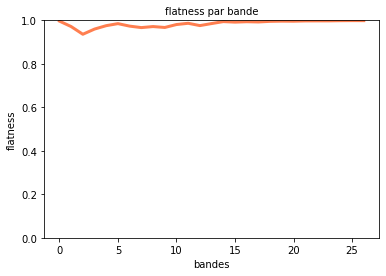

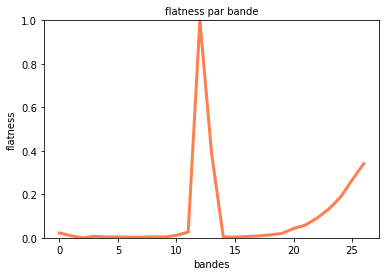

sp_flatness val max par bande S1: 99.9 % & freq de la bande: 9957.3 Hz
sp_flatness val min par bande S1: 93.6 % & freq de la bande: 48.2 Hz


In [39]:
# moyennes des amplitudes par ligne (des fréquences basses vers hautes)
def flatness_list (S):
    Sk_flat=[]
    Gmoy = gmoy_des_amps (S)
    Sk_mean = moy_des_amps(S)
    for k in range(27):
        Sk_flat.append(Gmoy[k]/Sk_mean[k])
    return Sk_flat

print ("Sk_flat:" , flatness_list(S1))


#********* graphic flatness S1 ***********
def plot_flatness(S):
    #plt.scatter(f_csA_midi, Sk_meanA)

    X = np.arange(0, 27, 1)
    Y = flatness_list(S)

    plt.plot(X, Y, color='coral', linewidth=3)
    #plt.grid()
    #plt.xlim(x_min, x_max)
    plt.ylim(0, 1.0)

    plt.title("flatness par bande", fontsize=10)
    plt.ylabel('flatness')
    plt.xlabel('bandes')

    plt.show()

plot_flatness (S1)
plot_flatness (S2)

#spectral flatness moyenne
def sp_flatness_moy(S):
    Sk_flat = flatness_list(S)
    Sm=0
    for k in range(27):
         Sm+=Sk_flat[k]
    return Sm/27

#formule equivalente
def sp_flatness_moy2(S):
    Sk_flat = flatness_list(S)
    Sk_flatA = np.asarray(Sk_flat)
    return Sk_flatA.mean()

def sp_flatness_max(S):
    Sk_flat = flatness_list(S)
    Sm=0
    for k in range(27):
        if Sm<Sk_flat[k]:
            Sm=Sk_flat[k]
            value = k
    return [value, f_c[value], Sm]
         
def sp_flatness_min(S):
    Sk_flat = flatness_list(S)
    Sm=1
    for k in range(27):
        if Sm>Sk_flat[k]:
            Sm=Sk_flat[k]
            value = k
    return [value, f_c[value], Sm]

def sp_flatness_maxamp(S):
    return sp_flatness_max(S)[2]
def sp_flatness_maxfreq(S):
    return sp_flatness_max(S)[1]
def sp_flatness_minamp(S):
    return sp_flatness_min(S)[2]
def sp_flatness_minfreq(S):
    return sp_flatness_min(S)[1]

print("sp_flatness val max par bande S1:", round(100*sp_flatness_maxamp(S1),1), "% & freq de la bande:", round(sp_flatness_maxfreq(S1),1), "Hz")
print("sp_flatness val min par bande S1:", round(100*sp_flatness_minamp(S1),1), "% & freq de la bande:", round(sp_flatness_minfreq(S1),1), "Hz")


In [40]:
#sp crest
def sp_crest(S):
    Sk_mean = moy_des_amps(S)
    sum_skm=0
    K=27
    screst = 99 # si tout à zero
    max_skm=[]
    for k in range(27):
        sum_skm+=Sk_mean[k]
        for j in range(4+2*k):
            max_skm.append(np.max(S[k][j]))
    max_sk=max(max_skm)
    if sum_skm > 0:
        screst=max_sk/((1/K)*sum_skm)
    return screst

print("sp_crest S1:" , sp_crest(S1))
print("sp_crest S2:" , sp_crest(S2))

sp_crest S1: 1.6403721103849755
sp_crest S2: 26.54025888450326


In [73]:
# rms with original value of frequency bin k=27
def rms(S):
    #Sk_mean = moy_des_amps(S)
    sum_skr = []
    for k in range(27):
        sum_sk = 0
        for j in range(LtailleLigne[k]):
            sum_sk += (S[k][j]**2)/LtailleLigne[k]
        sum_skr.append(sum_sk)
    #print(sum_skr)
    sum_rms=0
    for k in range(27):
        sum_rms += sum_skr[k]
    rms=sqrt(sum_rms)
    return rms  

def rms2(S):
    #Sk_mean = moy_des_amps(S)
    sum_skr=[]
    for k in range(27):
        sum_sk = fsum(np.multiply(S[k],S[k]))/LtailleLigne[k]
        sum_skr.append(sum_sk)
    #print(sum_skr)
    sum_rms=0
    for k in range(27):
        sum_rms += sqrt(sum_skr[k])
    rms = (sum_rms)
    return rms  

print("rms S0:", rms(S0))
print("rms S1:", rms(S1))
print("rms S2:", rms(S2))
print("rms S3:", rms(S3))

rms S0: 0.45830295032151447
rms S1: 0.15111840076635982
rms S2: 0.70701646126626
rms S3: 0.0578098138892505


In [59]:
# maxfreq25 (amp max de la bande 25) approx     
def maxfreq25(S):
    maxfreq25=max(S[25])
    return maxfreq25

In [60]:
# skewness (asymétrie du spectre – importance des fréquences graves) skw = 0 => spectre symétrique
def skewness0(S):
    Sk_mean = moy_des_amps(S)
    sum_sk=0
    sum_skm=0
    skewness = 0
    for k in range(27):
        sum_sk+=Sk_mean[k]*((f_c[k]-centroid(S))**3)
        sum_skm+=Sk_mean[k]
    if sum_skm > 0:
        if sd(S) > 0:
            skewness=(sum_sk/sum_skm)/(sd(S)**3)
    return skewness

def skewness(S):
    Sk_mean = moy_des_amps(S)
    sum_sk=0
    sum_skm=0
    for k in range(27):
        sum_sk+=Sk_mean[k]*((f_c[k]-centroid(S))**3)
        sum_skm+=Sk_mean[k]
    skewness=(sum_sk/sum_skm)/(sd(S)**3)
    return skewness


print("skewness", skewness(S1))


skewness 1.7093226209089747


In [61]:
# kurtosis 
def kurtosis(S):
    Sk_mean = moy_des_amps(S)
    sum_kt=0
    sum_skm=0
    kurtosis = 0
    for k in range(27):
        sum_kt+=Sk_mean[k]*((f_c[k]-centroid(S))**4)
        sum_skm+=Sk_mean[k]
    if sum_skm > 0:
        if sd(S) > 0:
            kurtosis=(sum_kt/sum_skm)/(sd(S)**4)
    return kurtosis

print("kurtosis", kurtosis(S1))

kurtosis 4.975074055912076


In [62]:
# freq au dessus de laquelle on a moins de 15% de l'énergie
def sp_rolloff(S):
    Sk_mean = moy_des_amps(S)
    sum_skm=0
    sum_rf=0
    for k in range(27):
        sum_skm+=Sk_mean[k]
    for k in range(27):
        sum_rf+=Sk_mean[k]
        if sum_rf>=0.85*sum_skm:
            rf=f_c[k]
            break
    return rf

## 4 Descripteurs temporels

variatemps 1 4.941940250431425
variatemps 2 0.5972403404784095
variatemps 3 5.2742613068426225
variatemps 4 0.3052720012805067


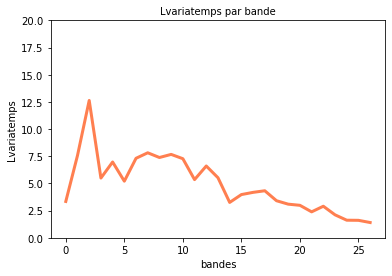

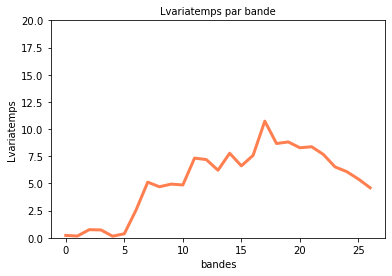

In [63]:
# variabilité temporelle sur une bande
def variatemps1 (bande):
    var = 0
    n = len(bande)
    for j in range(n-1):
        var += abs(bande[j]-bande[j+1])
    return var/(n-1)

#print (variatemp1([0,1, 2, -3]))

def variatemps (S):
    stS = 0
    for k in range(27):
        stS += variatemps1(S[k])
        #print ("S[k]:", S[k])
        #print ("stS :", stS)
    return stS*1000/27   

def Lvariatemps (S):
    LstS = []
    for k in range(27):
        stS = variatemps1(S[k])
        LstS.append(stS*1000)
    return LstS   
 
print("variatemps 1", variatemps(S1))
print("variatemps 2", variatemps(S2))
print("variatemps 3", variatemps(S3))
print("variatemps 4", variatemps(S4))


#********* graphic Lvariatemps Sx ***********
def plot_variatemps(S):

    X = np.arange(0, 27, 1)
    Y = Lvariatemps(S)

    plt.plot(X, Y, color='coral', linewidth=3)
    #plt.grid()
    #plt.xlim(x_min, x_max)
    plt.ylim(0, 20.0)

    plt.title("Lvariatemps par bande", fontsize=10)
    plt.ylabel('Lvariatemps')
    plt.xlabel('bandes')

    plt.show()

plot_variatemps (S1)
plot_variatemps (S3)

In [64]:
# écart-type des variations temporelles dans une bande

def ecartTpsAmps (S):
    Sk_ecarts = []
    for k in range(27):
        moyk = fsum(S[k])/(4+2*k)
        vark = 0
        for j in range(4+2*k):
            vark += pow(S[k][j] - moyk,2)
        vark = vark/(4+2*k)
        ecartk = sqrt(vark )
        Sk_ecarts.append(ecartk)
    return fsum(Sk_ecarts)*1000/27

print("ecartTps_des_amps 1 :",ecartTpsAmps(S1))
print("ecartTps_des_amps 2 :",ecartTpsAmps(S2))
print("ecartTps_des_amps 3 :",ecartTpsAmps(S3))
print("ecartTps_des_amps 4 :",ecartTpsAmps(S4))


ecartTps_des_amps 1 : 4.214618694762926
ecartTps_des_amps 2 : 2.2752163426204994
ecartTps_des_amps 3 : 3.797274045311866
ecartTps_des_amps 4 : 0.9907728407195441


In [65]:
# nbre de fois qu'on traverse entre m+s et m-s
# 

In [66]:
# similarité max & période dans une bande 0 = similaire
# nbande entre 0 et 26
  
def dissimilar (S , k):
    Lsimil = []
    for i in range(2+k):
        s = 0
        for j in range(2+k):
            s += fabs(S[k][j] - S[k][i+j+1])
        Lsimil.append(s)
    return Lsimil

def dissimilar25(S):
    return max(dissimilar(S, 25))
    
def dissimilar20(S):
    return max(dissimilar(S, 20))

def dissimilars(S):
    LDiss = []
    for i in range(k):
        LDiss.append (mean(dissimilar(S, i)))
    return mean(LDiss)

print (dissimilar25(S3))
print (dissimilars (S3))

0.227101
0.07739185059645226


In [67]:
# proposition de période d'un 
def find1stMin(L):
    "donne la première valeur croissante après avoir passé le troisième quartile puis le premier"
    quant = quantiles(L, n=3)  
    med1 = quant[0]
    med3 = quant[1]
    #print("meds :", med1, "- ", med3)
    test = 0
    val = 0
    n = len(L)
    result = 0
    for i in range(n):
        if (test == 0 and L[i]>med3):
            test = 1
        elif (test == 1 and L[i]<med1):
            test = 2
            val = L[i]
        elif (test == 2 and val < L[i]):
            result = val
            test == 3
            break
        else :
            val = L[i]            
    return (result/(max (L)), (i-1)/n)

def maxdist(L):
    res = find1stMin(L)
    return (res[0])

def maxdist25(S):
    return maxdist(dissimilar(S, 25))

def maxdist20(S):
    return maxdist(dissimilar(S, 20))
    
def period(Liste):
    "en %"
    res = find1stMin(Liste)
    return (res[1])

def period25 (S) :
    return period(dissimilar(S, 25))
    
def period20 (S) :
    return period(dissimilar(S, 20))
    
#find1stMin([1, 2, 3, 4, 3, 2.2, 1.1, 0, 1, 2.6, 3, 4, 5])   
#find1stMin(similarity(S3, 25))
#maxdist(similarity(S3, 25))
#period20(S3)
maxdist25(S3)

0.2259787495431547

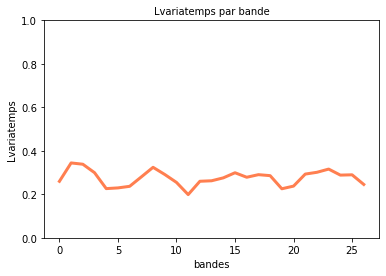

In [68]:
#********* graphic Lvariatemps Sx ***********
def plot_dissimilar(S , nbande):

    X = np.arange(0, nbande+2, 1)
    Y = dissimilar(S, nbande)

    plt.plot(X, Y, color='coral', linewidth=3)
    #plt.grid()
    #plt.xlim(x_min, x_max)
    plt.ylim(0, 1.0)

    plt.title("Lvariatemps par bande", fontsize=10)
    plt.ylabel('Lvariatemps')
    plt.xlabel('bandes')

    plt.show()

plot_dissimilar (S0, 25)

In [74]:
# spectral flux

def interpolA (bande, x):
    "x entre 0 et 1 - donne la valeur interpolée dans la liste de float de bande"
    n = len(bande)-1
    if (x == 1):
        result = bande[n]
    else :
        ninf = int(x * n)
        nsup = ninf + 1
        ainf = bande[ninf]
        asup = bande[nsup]
        dx = (x * n) - ninf
        result = ainf + dx * (asup - ainf)
        #print ("ninf ", ninf, "nsup ", nsup, "ainf ", ainf, "dx ", dx)
    return result

#print (interpolA ([0.19, 0.19, 0.69, 0.61, 0.13, 0.60], 0.1))

def spectFlux (S, nvals):
    table = []
    for i in range (nvals) :
        #print (i)
        tablei = []
        for k in range (27):
            tablei.append(interpolA(S[k], i/nvals))
        table.append(tablei)
    print (table)
    flux = 0
    for i in range (nvals - 1):
        for k in range (27):
            flux += pow(table[i][k] - table[i+1][k],2) 
    return flux
        
        
print ("rms sinus500 : ", rms(S2), "flux : ", spectFlux(S2, 2)/rms(S2))
print ("rms PinkNoisePk_05Hz: ", rms(S3), "flux : ", spectFlux(S3, 5)/rms(S3), "\n")

def specFluxPente (S):
    ()
    

[[0.002026, 0.002477, 0.002865, 0.003214, 0.006091, 0.006671, 0.009469, 0.010426, 0.013828, 0.018287, 0.028387, 0.057809, 0.696218, 0.071105, 0.023932, 0.014335, 0.008833, 0.006143, 0.004276, 0.003004, 0.002185, 0.001577, 0.001156, 0.000859, 0.000647, 0.000502, 0.000404], [2e-06, 1e-06, 0.0, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 2e-06, 2e-06, 1e-05, 4.55e-05, 0.706781, 0.0011884999999999999, 2e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1.5e-06, 1.5e-06, 2e-06, 2.4999999999999998e-06, 2.4999999999999998e-06, 2.4999999999999998e-06, 3.5e-06]]
rms sinus500 :  0.70701646126626 flux :  0.015427080464951707
[[0.013217, 0.011013, 0.005256, 0.006498, 0.011236, 0.011588, 0.014844, 0.014765, 0.012807, 0.015249, 0.017064, 0.01672, 0.017676, 0.014975, 0.01735, 0.015201, 0.013433, 0.018089, 0.015785, 0.016018, 0.015355, 0.015866, 0.015314, 0.014329, 0.013415, 0.012559, 0.010191], [0.0133178, 0.011061, 0.0046878, 0.0051922, 0.011617800000000001, 0.0116202, 0.008544, 0.0139858, 0.0088874, 0.010186800000000

In [72]:
int(0.999)


0

In [306]:
#********************** Analyses *********************
#********************** Pour Excel *******************
#*****************************************************

class Analyse:
    def __init__(self, filename, mc_min_eclow, midi_centroid, mc_plus_ecHi, midi_sp_slope, skewness, kurtosis, 
                 sp_rolloff, sp_flatness_Na, sp_flatness, sp_crest, rms, maxfreq25, variatemps, 
                 ecartTpsAmps, dissimilars, dissimilar25, dissimilar20, maxdist25, maxdist20, period25, period20):
        self.filename = filename
        self.mc_min_eclow=mc_min_eclow
        self.midi_centroid=midi_centroid
        self.mc_plus_ecHi=mc_plus_ecHi
        self.midi_sp_slope=midi_sp_slope
        self.skewness=skewness
        self.kurtosis=kurtosis
        self.sp_rolloff=sp_rolloff
        self.sp_flatness_Na=sp_flatness_Na
        self.sp_flatness=sp_flatness
        self.sp_crest=sp_crest
        self.rms=rms
        self.maxfreq25=maxfreq25
        self.variatemps=variatemps
        self.ecartTpsAmps=ecartTpsAmps
        self.dissimilars=dissimilars
        self.dissimilar25=dissimilar25
        self.dissimilar20=dissimilar20
        self.maxdist25=maxdist25
        self.maxdist20=maxdist20
        self.period25=period25
        self.period20=period20


with open('../Xparams_Kawa.txt', 'w') as f:
    for fichier in filelist:
        #print (fichier, file=f)
        #print (centroid(fichier))
        print(fichier + "\t" 
              #+str(timetxt(fichier))+"\t"
              +str(mc_min_eclow(read(fichier)))+"\t"
              +str(midi_centroid(read(fichier)))+"\t"
              +str(mc_plus_ecHi(read(fichier)))+"\t"
              +str(midi_sp_slope(read(fichier)))+"\t"
              +str(skewness(read(fichier)))+"\t"
              +str(kurtosis(read(fichier)))+"\t"
              +str(sp_rolloff(read(fichier)))+"\t"
              +str(sp_flatness_Na(read(fichier)))+"\t"
              +str(sp_flatness(read(fichier)))+"\t"
              +str(sp_crest(read(fichier)))+"\t"
              +str(rms(read(fichier)))+"\t"
              +str(maxfreq25(read(fichier)))+"\t"
              +str(variatemps(read(fichier)))+"\t"
              +str(ecartTpsAmps(read(fichier)))+"\t"
              +str(dissimilars(read(fichier)))+"\t"
              +str(dissimilar25(read(fichier)))+"\t"
              +str(dissimilar20(read(fichier)))+"\t"
              +str(maxdist25(read(fichier)))+"\t"
              +str(maxdist20(read(fichier)))+"\t"
              +str(period25(read(fichier)))+"\t"
              +str(period20(read(fichier)))
              , file=f)

